In [1]:
mod_input=True
mod_topo=True
leak_rate = 0.2
gradient= 0.00075# 0.0005
gain = 1.75
radical=False
radical_bis=False
grad2=1.25
breadth=600
expon=3

res_seed = 4

# baseline with slow leak rate

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab
import statsmodels.api as sm

import seaborn as sns

import csv

import scipy
from scipy import stats
from scipy.ndimage import gaussian_filter1d

import random


In [3]:
#import cupy as cp
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import numpy as np
from wikipedia2vec import Wikipedia2Vec

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


vectorDim = 100

numNode = 1000

#inputDataTraining = np.load('./trainingData_averaging/inputDataTraining_4k_average.npy')
#outputDataTraining = np.load('./trainingData_averaging/outputDataTraining_4k_average.npy')
#print(len(inputDataTraining))
#print(len(outputDataTraining))

Using Numpy backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PeterDell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


In [5]:
#reservoirStatesBuffer[:,:resn]

#in_small = inputDataTraining[:10000]
#out_small = outputDataTraining[:10000]


#np.save('in_small.npy', in_small)
#np.save('out_small.npy', out_small)

in_small = np.load('C:/Users/PeterDell/Google Drive/GoogleWIP/People/Uchida/PaperMethods/UchidaPrograms/in_small.npy')
out_small = np.load('C:/Users/PeterDell/Google Drive/GoogleWIP/People/Uchida/PaperMethods/UchidaPrograms/out_small.npy')

print(len(in_small))
print(len(out_small))

10000
10000


In [6]:
wiki2vec = Wikipedia2Vec.load('C:/Users/PeterDell/Google Drive/GoogleWIP/People/Uchida/PaperMethods/UchidaPrograms/enwiki_20180420_100d.pkl')



In [7]:
temp_W=np.zeros([1000,1000])

In [8]:
inputDataTesting = np.load("synthetic_narrative2.npy")
ground_truth_sums = np.load("synthetic_narrative2-gt.npy")

In [9]:
#to shuffle or notto suffle!
do_shuffle = True
if do_shuffle:
    random.shuffle(inputDataTesting)
    random.shuffle(inputDataTesting)
    random.shuffle(inputDataTesting)
        
for res_seed in range(40):
# set the seed
    np.random.seed(res_seed)

    # set up the reservoir
    # leakingRate=0.2 changing too fast, mutliple with 0.05; changed
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=leak_rate, regressionParameters=[1e-2], solver="lsqr", feedback=False)

    # train the reervoir with a new seed
    esn.fit(in_small, out_small, transientTime="Auto", verbose=1)
    


    # modify the reservoir topology for input
    if mod_input:
        for i in range(700):
            for j in range(101):
                esn._WInput[i+300,j] = 0
        esn._WInput=esn._WInput*5

    #radical _W modification
    if mod_topo:
        for i in range(1000):
            for j in range(1000):
                temp_W[i,j] = esn._W[i,j]
        for i in range(1000):
            for j in range(1000):
                esn._W[i,j]=0
        for i in range(esn._W.shape[0]):
            for j in range(esn._W.shape[1]):
                if abs(i-j) <= breadth:
                    esn._W[i,j] = ((breadth-abs(i-j))/breadth)**expon*temp_W[i,j]* (1 + i * gradient)*gain
    if radical:
        for i in range(100,200):
            for j in range(800,900):
                esn._W[j,i] = temp_W[j,i]*grad2

    if radical_bis:
        for i in range(100,200):
            for j in range(800,900):
                esn._W[i,j] = temp_W[j,i]*grad2


    #run the reservoir
    reservoirStatesBuffer = np.empty((0,numNode))
    prediction,reservoirStatesBuffer  = esn.predict(inputDataTesting)
    reservoirStatesBuffer = reservoirStatesBuffer.T
    print(reservoirStatesBuffer.shape)
    reservoirStatesBuffer = reservoirStatesBuffer[:,101:]
    print(reservoirStatesBuffer.shape)
    print(prediction.shape)

    # set the similarity matrix
    sim_matrix1 = np.empty([len(reservoirStatesBuffer),len(reservoirStatesBuffer)])

    print(len(reservoirStatesBuffer[1]))

    reservoirStatesBuffer1 = reservoirStatesBuffer

    if do_shuffle:
        file_string = "synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_%d.npy" % (res_seed)
    else:
        file_string = "synth_narr_reservoirs/structured_synthetic_intact/data/struct_synthet_intact_%d.npy" % (res_seed)
    print("saving file", file_string)
    np.save(file_string,reservoirStatesBuffer)
    
    #plot figure to verigy
    resn = 50
    begin=0
    end=2200
    rbegin = 900
    rend = 910
    fig= plt.figure(figsize=(10,12))

    plt.subplot(611)
    plt.plot( reservoirStatesBuffer1[begin:end,100:105])
    plt.title('Hierarchical 100:105')

    plt.subplot(612)
    plt.plot( reservoirStatesBuffer1[begin:end,300:305])
    plt.title('Hierarchical 300:305')

    plt.subplot(613)
    plt.plot( reservoirStatesBuffer1[begin:end,500:505])
    plt.title('Hierarchical 500:505')

    plt.subplot(614)
    plt.plot( reservoirStatesBuffer1[begin:end,700:705])
    plt.title('Hierarchical 700:705')

    plt.subplot(615)
    plt.plot( reservoirStatesBuffer1[begin:end,900:905])
    plt.title('Hierarchical 900:905')

    plt.subplot(616)
    plt.plot( inputDataTesting[begin:end,:])
    plt.title('Input')

    fig.tight_layout()

    if do_shuffle:
        plt.savefig('synth_narr_reservoirs/structured_synthetic_scrambled/figures/struct_synthet_scrambled_%d.png' % (res_seed))
    else:
        plt.savefig('synth_narr_reservoirs/structured_synthetic_intact/figures/struct_synthet_intact_%d.png' % (res_seed))
        
    numNode=1000
    for j in range(numNode):
        mean = reservoirStatesBuffer[:,j].mean()
        if abs(mean) > 0.001:
            reservoirStatesBuffer[:,j] = reservoirStatesBuffer[:,j]/mean
        
    fig= plt.figure(figsize=(10,8))
    sns.heatmap(np.corrcoef(reservoirStatesBuffer[:,:]),cmap='viridis')#sns.heatmap(sim_matrix, square=True)
    for i in ground_truth_sums:
        plt.plot(i, i,marker="o", markersize=8, markeredgecolor="red", markerfacecolor="red")

    if do_shuffle:
        plt.savefig('synth_narr_reservoirs/structured_synthetic_scrambled/figures/struct_heat_scrambled_%d.png' % (res_seed))
    else:
        plt.savefig('synth_narr_reservoirs/structured_synthetic_intact/figures/struct_heat_intact_%d.png' % (res_seed))
        
        
        
    plt.close('all')    

100% (9904 of 9904) |####################| Elapsed Time: 0:00:05 Time:  0:00:05


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_0.npy


100% (9906 of 9906) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_1.npy


100% (9902 of 9902) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_2.npy


100% (9906 of 9906) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_3.npy


100% (9903 of 9903) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_4.npy


100% (9908 of 9908) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_5.npy


100% (9905 of 9905) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_6.npy


100% (9903 of 9903) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_7.npy


100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_8.npy


100% (9910 of 9910) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_9.npy


100% (9899 of 9899) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_10.npy


100% (9906 of 9906) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_11.npy


100% (9906 of 9906) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_12.npy


100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_13.npy


100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_14.npy


100% (9901 of 9901) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_15.npy


100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_16.npy


100% (9905 of 9905) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_17.npy


100% (9903 of 9903) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_18.npy


100% (9905 of 9905) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_19.npy


100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_20.npy


100% (9903 of 9903) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_21.npy


100% (9902 of 9902) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_22.npy


100% (9904 of 9904) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_23.npy


100% (9911 of 9911) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_24.npy


100% (9903 of 9903) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_25.npy


100% (9902 of 9902) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_26.npy


100% (9903 of 9903) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_27.npy


100% (9909 of 9909) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_28.npy


100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_29.npy


100% (9907 of 9907) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_30.npy


100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_31.npy


100% (9904 of 9904) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_32.npy


100% (9908 of 9908) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_33.npy


100% (9908 of 9908) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_34.npy


100% (9904 of 9904) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_35.npy


100% (9901 of 9901) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_36.npy


100% (9906 of 9906) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_37.npy


100% (9905 of 9905) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_38.npy


100% (9902 of 9902) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1740, 1101)
(1740, 1000)
(1740, 100)
1000
saving file synth_narr_reservoirs/structured_synthetic_scrambled/data/struct_synthet_scrambled_39.npy


In [10]:
#np.save('reservoir_sherlock_hierarchy_seed4.npy',reservoirStatesBuffer)

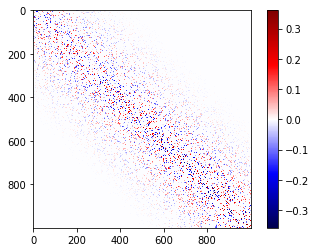

In [11]:
plt.imshow(esn._W,cmap='seismic')
plt.colorbar()

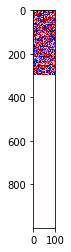

In [12]:
plt.imshow(esn._WInput,cmap='seismic' )

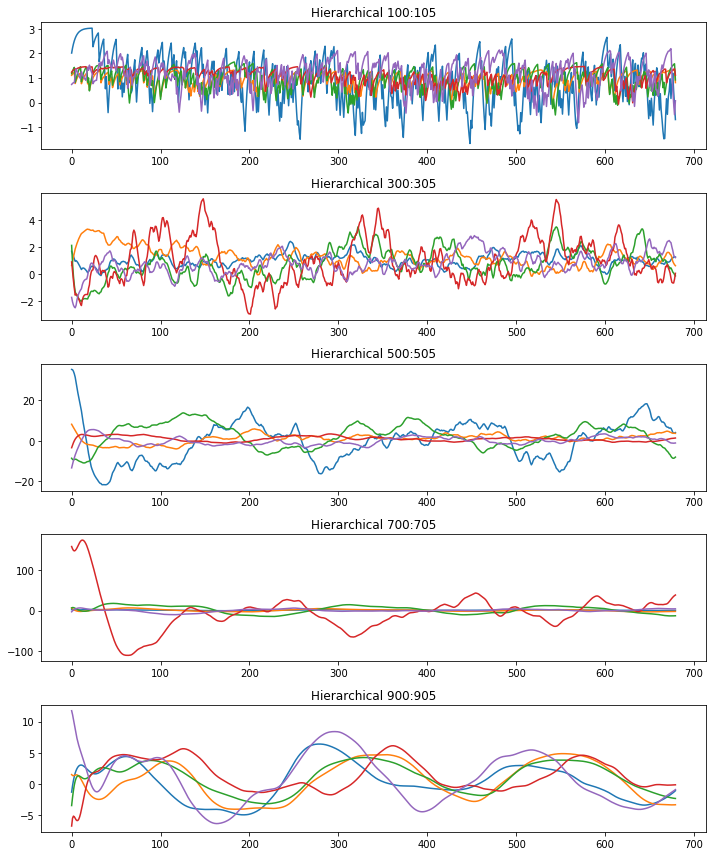

In [13]:
resn = 50
begin=0
end=680
rbegin = 900
rend = 910
fig= plt.figure(figsize=(10,12))

plt.subplot(511)
plt.plot( reservoirStatesBuffer1[begin:end,100:105])
plt.title('Hierarchical 100:105')

plt.subplot(512)
plt.plot( reservoirStatesBuffer1[begin:end,300:305])
plt.title('Hierarchical 300:305')

plt.subplot(513)
plt.plot( reservoirStatesBuffer1[begin:end,500:505])
plt.title('Hierarchical 500:505')

plt.subplot(514)
plt.plot( reservoirStatesBuffer1[begin:end,700:705])
plt.title('Hierarchical 700:705')

plt.subplot(515)
plt.plot( reservoirStatesBuffer1[begin:end,900:905])
plt.title('Hierarchical 900:905')


fig.tight_layout()

#plt.savefig('temporal_hierarchy.png')

In [14]:
print(reservoirStatesBuffer1.shape)

(1740, 1000)


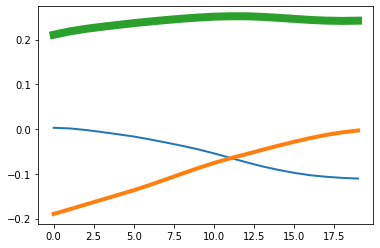

In [15]:
plt.plot( sm.tsa.stattools.ccf(reservoirStatesBuffer1[:,300], reservoirStatesBuffer1[:,350])[:20],linewidth=2 )
plt.plot( sm.tsa.stattools.ccf(reservoirStatesBuffer1[:,300], reservoirStatesBuffer1[:,450])[:20],linewidth=4 )
plt.plot( sm.tsa.stattools.ccf(reservoirStatesBuffer1[:,300], reservoirStatesBuffer1[:,550])[:20],linewidth=8 )

In [16]:
reservoirStatesBuffer1.shape

(1740, 1000)

In [17]:
areas = 20
factor = int(numNode/areas)
roi_data = np.zeros([areas,reservoirStatesBuffer1.shape[0]])
print(roi_data.shape)
print(factor)

(20, 1740)
50


In [18]:
for i in range(areas): # create 10 sub areas
    for j in range (reservoirStatesBuffer1.shape[0]): #for each timestep
        roi_data[i,j] = np.mean(reservoirStatesBuffer1[j,i*factor:(i+1)*factor])

In [19]:
reservoirStatesBuffer1[j,i*factor:(i+1)*factor]

array([ 2.40280957e-01, -3.14729148e+01,  3.70361467e-01, -2.32344271e+00,
        1.84077568e+00,  1.68305022e+00,  1.74850921e+01,  3.07389033e-01,
        5.67103496e-01,  2.37833195e+00,  4.11907492e-03,  6.33120617e-01,
       -1.26074597e+01, -3.39530737e+00,  1.06117893e+01,  2.49148820e+00,
        2.32096700e+00, -1.30192898e+00,  1.24001875e+00, -1.37403037e+00,
        1.11245784e+02,  7.70575805e-01,  1.47430191e+00,  3.14063837e+00,
        9.67696207e-01,  7.37946705e-01,  3.02258722e-01, -4.32487531e+00,
        6.85764786e-01, -2.86556013e+00,  1.30314472e+01, -1.63042113e+00,
        9.74828993e-01,  8.26914154e-02,  1.28885110e+00,  1.36328251e+01,
        1.68760386e+00,  1.22412147e+00, -4.04558469e+00,  2.92008197e+00,
        1.58310971e+00,  3.71731233e+00,  7.14644744e+00,  6.28324218e+00,
       -2.39926926e+00, -5.49820027e+00, -5.67582189e+00, -8.31508236e+00,
        1.49771080e+00,  2.06909294e+00])

[]

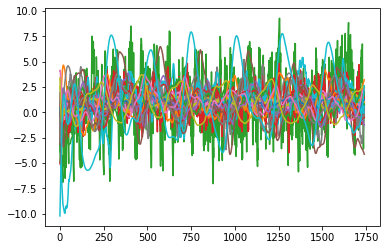

In [20]:
plt.plot(roi_data.T)

plt.plot()

[]

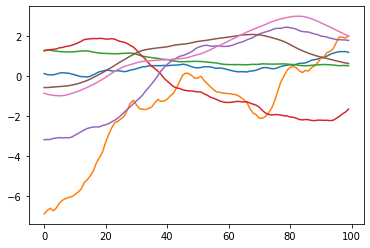

In [21]:
plt.plot(roi_data[8:15,50:150].T)

plt.plot()

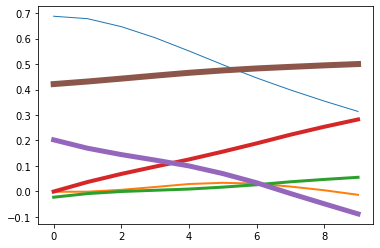

In [22]:
source = 6
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[8,50:150].T)[:10],linewidth=1 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[10,50:150].T)[:10],linewidth=2 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[12,50:150].T)[:10],linewidth=3 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[14,50:150].T)[:10],linewidth=4 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[16,50:150].T)[:10],linewidth=5 )
plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[18,50:150].T)[:10],linewidth=6 )
#plt.plot( sm.tsa.stattools.ccf(roi_data[source,50:150].T, roi_data[19,50:150].T)[:10],linewidth=7 )

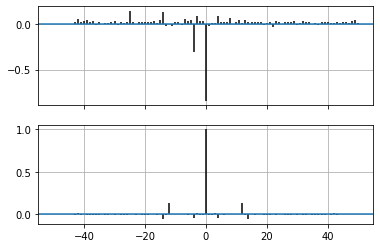

In [23]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(reservoirStatesBuffer1[700,50:150].T, reservoirStatesBuffer1[800,50:150].T, usevlines=True, maxlags=50, normed=True)
ax1.grid(True)

ax2.acorr(reservoirStatesBuffer1[16,50:150].T, usevlines=True, normed=True, maxlags=50)
ax2.grid(True)

plt.show()

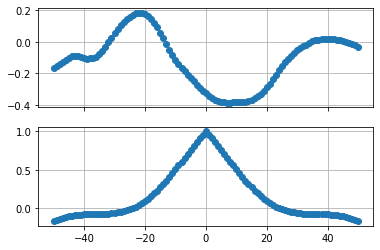

In [27]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
ax1.xcorr(roi_data[7,50:150].T, roi_data[6,50:150].T, usevlines=False, maxlags=50, normed=True)
ax1.grid(True)

ax2.acorr(roi_data[16,50:150].T, usevlines=False, normed=True, maxlags=50)
ax2.grid(True)

plt.show()






In [25]:
wiki2vec.get_word_vector("aezr")

KeyError: 

In [ ]:
word = "qsdf"
if '<Word sangane>' in wiki2vec.dictionary:
    print("great")

In [ ]:
for token in wiki2vec.dictionary:
    print(token)

In [ ]:
if wiki2vec.get_word('qsdfqsdf'):
    print("great")